<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/PCA_1DCNN_(binary_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

Extraction

In [69]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' else 1)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


#Data Split

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of split

Input Shapes -> Train: (1613280, 52), Val: (403320, 52), Test: (504151, 52)
Labels[Benign, Mal] -> Train: [1340836  272444], Val: [335209  68111], Test: [419012  85139]


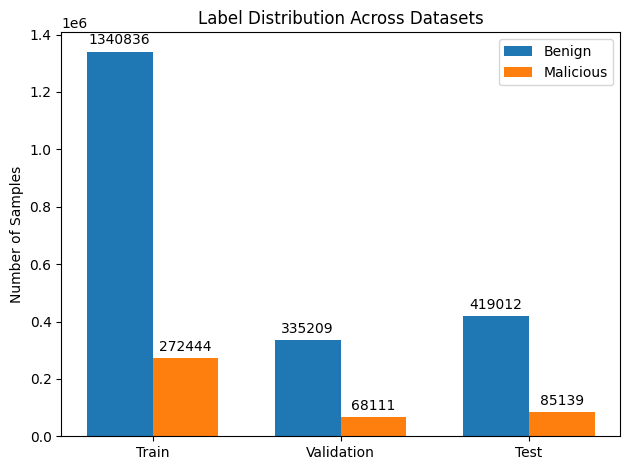

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# --- Visualisation ---
print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels[Benign, Mal] -> Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Data for plotting
labels = ['Benign', 'Malicious']
datasets = ['Train', 'Validation', 'Test']
counts = [train_counts, val_counts, test_counts]

# Get the counts of benign and malicious samples in each count variable
benign_counts = [c[0] for c in counts]
mal_counts = [c[1] for c in counts]

x = np.arange(len(datasets))  # Set the label locations on the graph
width = 0.35  # Set the width of the bars on the graph

# Create the plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign')
rects2 = ax.bar(x + width/2, mal_counts, width, label='Malicious')

# Add graph labels and title
ax.set_ylabel('Number of Samples')
ax.set_title('Label Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Add the value labels to the graph
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show() # Display the graph

#Normalisation

In [72]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
#scaler = MinMaxScaler() # Initialize the scaler
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train_scaled = scaler.fit_transform(X_train) # Standardise data features accoriding to th training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train_scaled.shape}")
print(f"Shape of X_val after scaling: {X_val_scaled.shape}")
print(f"Shape of X_test after scaling: {X_test_scaled.shape}")

Shape of X_train after scaling: (1613280, 52)
Shape of X_val after scaling: (403320, 52)
Shape of X_test after scaling: (504151, 52)


#Apply PCA
Principal component analysis (PCA) is a dimensionality reduction and unsuprevised machine learning method used to simplify a large data set into a smaller set while still maintaining
significant patterns and trends.
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first

Number of principle components: 25


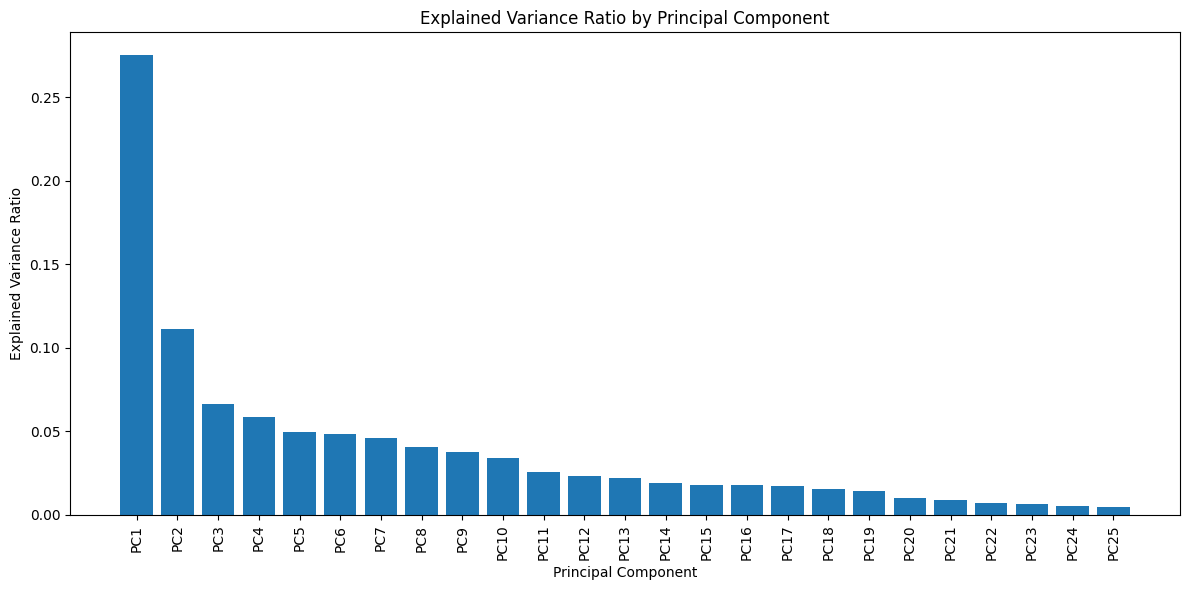

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA # Import PCA

# Make an instance of the pca model
#pca = PCA(0.95) # sklearn chooses the minimum number of principal components such that 95 percent of the variance in the data is retained
pca = PCA(n_components = 25)


# Only fit the PCA to the training data
pcaX_train = pca.fit_transform(X_train_scaled) # To avoid data leakage (information from the test set influences the model during training)
pcaX_val = pca.transform(X_val_scaled) # Apply the PCA to the validation data
pcaX_test = pca.transform(X_test_scaled) # Apply the PCA to the test data

print(f"Number of principle components: {pca.n_components_}")

# --- Visualise variance distribution ---

# Get explained variance ratio from the PCA object
explained_variance_ratio = pca.explained_variance_ratio_

# Create labels for the x-axis (PC1, PC2, ...)
pc_labels = [f'PC{i+1}' for i in range(len(explained_variance_ratio))]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(pc_labels, explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout()
plt.show()

#Scatter plots of PCA
https://plotly.com/python/pca-visualization/

PCA scatter matrix:

In [74]:
import plotly.express as px
import pandas as pd

pcaX_train_features = [] # Create PCA feature list

for i in range(pca.n_components_):
  pcaX_train_features.append(f'PC{i+1}') #Label the PC components and add them to list

print(f"PCA features: {pcaX_train_features}")

# Create a DataFrame from the PCA results with column names
pca_train_df = pd.DataFrame(data=pcaX_train, columns=pcaX_train_features)

# Add the original labels for coloring
pca_train_df['label'] = y_train

display(pca_train_df.head())

fig = px.scatter_matrix(
     pca_train_df,
     dimensions= pcaX_train_features[:10], # Changed to show only the first 10 PCs
     color="label"
)
fig.update_traces(diagonal_visible=False)

import plotly.offline as offline
# Save the figure as an HTML file
offline.init_notebook_mode(connected=True)
fig.write_html("pca_scatter_matrix_first_10pcs.html") # file name
print("PCA scatter plot saved as pca_scatter_matrix_first_10pcs.html")

# fig.show()

PCA features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25']


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,label
0,-1.989526,0.449502,-0.655980,-1.354040,0.859964,0.037562,-0.893245,0.536159,0.048616,0.287599,0.244498,-0.003294,-0.093923,0.104080,0.003796,0.113512,0.013622,-0.084273,-0.172645,0.070441,-0.003045,-0.039157,-0.011936,0.384403,0.186460,0.0
1,-1.985202,0.428304,-0.485330,-0.956570,0.523142,0.020191,-0.685192,0.252143,0.027897,0.095636,0.138053,-0.000449,-0.036501,-0.053223,-0.002472,-0.023122,0.008824,0.064698,0.021973,-0.303199,-0.117926,-0.258001,0.014894,0.671672,0.348838,0.0
2,-2.202463,0.395258,0.179619,4.504113,0.627103,0.622335,0.622705,1.106391,0.036393,1.496978,0.151604,-0.044670,-0.172709,-0.688683,0.001108,0.095770,-0.945575,0.475321,-1.104563,0.125206,-0.134115,0.397507,0.070351,0.151786,0.014986,0.0
3,9.708348,-1.852086,11.572719,1.728493,10.026148,-6.589385,-0.408145,1.146534,0.046496,-2.827845,-0.377623,1.542584,0.156636,-0.050463,-0.047379,-1.634278,-0.381963,-1.225413,-0.692678,0.434632,-0.175524,-0.730327,0.121919,-0.100102,0.107473,0.0
4,-1.935658,0.344011,-0.836765,-1.427868,0.904866,0.125260,-0.943282,0.632670,0.055964,0.535510,0.255013,-0.058289,-0.118547,0.221168,-0.001392,-0.099922,0.197651,-0.741241,-0.381362,0.594748,0.163296,0.346744,-0.020492,-0.987023,-0.597153,0.0


PCA scatter plot saved as pca_scatter_matrix_first_10pcs.html


PC1 vs PC2

Testing:

In [75]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

# Apply the already fitted PCA to the scaled training data
# We only take the first 2 principal components for visualization
X_pca = pca.transform(X_train_scaled)[:, :2]

# Create a DataFrame with the two principal components
pca_train_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Map the numeric labels (0 and 1) to descriptive strings ('Benign' and 'Malicious')
label_map = {0: 'Benign', 1: 'Malicious'}
pca_train_df['Label'] = pca_train_df.index.map(lambda i: label_map[y_train.iloc[i]])


# Sample 20,000 data points from each class (Benign and Malicious)
# This is done to make the scatter plot easier to visualize for a large dataset
benign_df = pca_train_df[pca_train_df['Label'] == 'Benign'].sample(n=20000, random_state=42)
malicious_df = pca_train_df[pca_train_df['Label'] == 'Malicious'].sample(n=20000, random_state=42)

# Combine the sampled dataframes
pca_sample_df = pd.concat([benign_df, malicious_df], ignore_index=True)

# Calculate the explained variance ratio for the first two principal components
# This is used for the axis labels in the plot
explained_var = pca.explained_variance_ratio_ * 100

# Define the colors for the different labels in the plot
color_discrete_map = {
    'Malicious': 'red',
    'Benign': 'blue'
}

# Create the scatter plot using Plotly Express
fig = px.scatter(
    pca_sample_df,
    x='PC1',
    y='PC2',
    color='Label',
    opacity=0.5, # Set transparency of the points
    color_discrete_map=color_discrete_map,
    title=f'PCA Scatter Plot: PC1 ({explained_var[0]:.2f}%) & PC2 ({explained_var[1]:.2f}%) Variance Explained',
    labels={
        'PC1': f'PC1 ({explained_var[0]:.2f}%)',
        'PC2': f'PC2 ({explained_var[1]:.2f}%)',
        'Label': 'Label'
    }
)

# Increase the size of the markers in the plot
fig.update_traces(marker=dict(size=5))

# # Display the plot
# fig.show()

import plotly.offline as offline

# Save the figure as an HTML file
offline.init_notebook_mode(connected=True)
fig.write_html("pc1_vs_pc2_scatter_plot.html")
print("PCA scatter plot saved as pca_scatter_plot.html")

PCA scatter plot saved as pca_scatter_plot.html


# Data reshaping for 1D CNN input

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Reshape the data so it can be used as input for the 1D CNN
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = pcaX_train.reshape((pcaX_train.shape[0], pcaX_train.shape[1], 1))
X_val = pcaX_val.reshape((pcaX_val.shape[0], pcaX_val.shape[1], 1))
X_test = pcaX_test.reshape((pcaX_test.shape[0], pcaX_test.shape[1], 1))

# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1613280, 25, 1)
Validation input shape: (403320, 25, 1)
Test input shape: (504151, 25, 1)


#1D CNN model

In [77]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# # Define the 1D CNN Model

# # Define input shape
# input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# # Build model
# model = Sequential([
#     Input(shape=input_shape),
#     Conv1D(filters=64, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
#     BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
#     MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
#     Dropout(0.25), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

#     Conv1D(filters=128, kernel_size=3, activation='relu'),#kernel_size=3
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
#     Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
#     Dropout(0.5), # Randomly drop 50% of the network's neurons to further prevent overfitting
#     Dense(1, activation='sigmoid')  # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0))
# ])

# # Compile
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels

# #Summary
# #model.summary()

Adding complexity

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=64, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.25), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.3), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(1, activation='sigmoid')  # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0))
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels

#Summary
#model.summary()

#Train 1D CNN

Epoch 1/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 132s 5ms/step - accuracy: 0.9654 - loss: 0.0986 - val_accuracy: 0.9727 - val_loss: 0.0644
Epoch 2/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9755 - loss: 0.0582 - val_accuracy: 0.9776 - val_loss: 0.0477
Epoch 3/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 144s 5ms/step - accuracy: 0.9770 - loss: 0.0540 - val_accuracy: 0.9804 - val_loss: 0.0465
Epoch 4/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accuracy: 0.9776 - loss: 0.0523 - val_accuracy: 0.9767 - val_loss: 0.0531
Epoch 5/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9783 - loss: 0.0505 - val_accuracy: 0.9805 - val_loss: 0.0454
Epoch 6/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9788 - loss: 0.0494 - val_accuracy: 0.9825 - val_loss: 0.0433
Epoch 7/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - accuracy: 0.9793 - loss: 0.0482 - val_accuracy: 0.9817 - val_loss: 0.0409
Epoch 8/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - ac

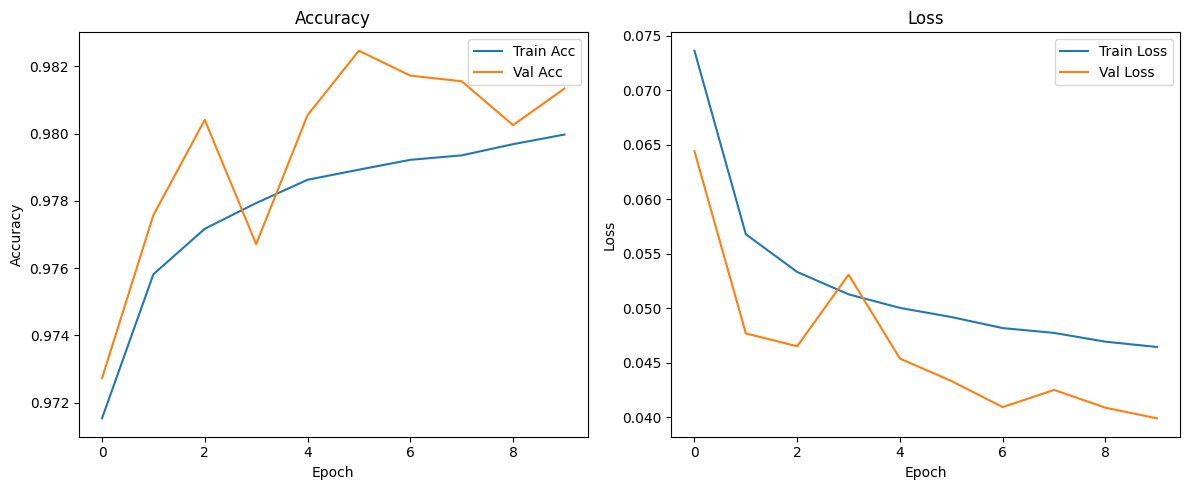

In [79]:
import matplotlib.pyplot as plt
import timeit

# Train the Model
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot accuracy and loss
plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [80]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions of x_test dataset
threshold = 0.5
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > threshold).astype(int).flatten()  # Convert probabilities to 0 or 1, 0.5 = Threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy scores
print("Accuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")
print(f"Confusion Matrix Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
print(f"{(tp/(tp+fn))*100:.4f}% of malware identified")
print(f"{(fp/(fp+tn))*100:.4f}% of benign traffic incorrectly identified")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

15755/15755 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step
Confusion Matrix:
[[415368   3644]
 [  5855  79284]]

True Negatives (Benign correctly classified): 415368
False Positives (Benign misclassified as malware): 3644
False Negatives (Malware missed): 5855
True Positives (Malware correctly identified): 79284
Accuracy:
sklearn Accuracy: 0.9811584227741291
model.evaluate Accuracy: 0.9812
Confusion Matrix Accuracy: 0.9811584227741291
93.1230% of malware identified
0.8697% of benign traffic incorrectly identified

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    419012
   Malicious       0.96      0.93      0.94     85139

    accuracy                           0.98    504151
   macro avg       0.97      0.96      0.97    504151
weighted avg       0.98      0.98      0.98    504151



#Visualisation of results

/tmp/ipython-input-2967908928.py:33: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



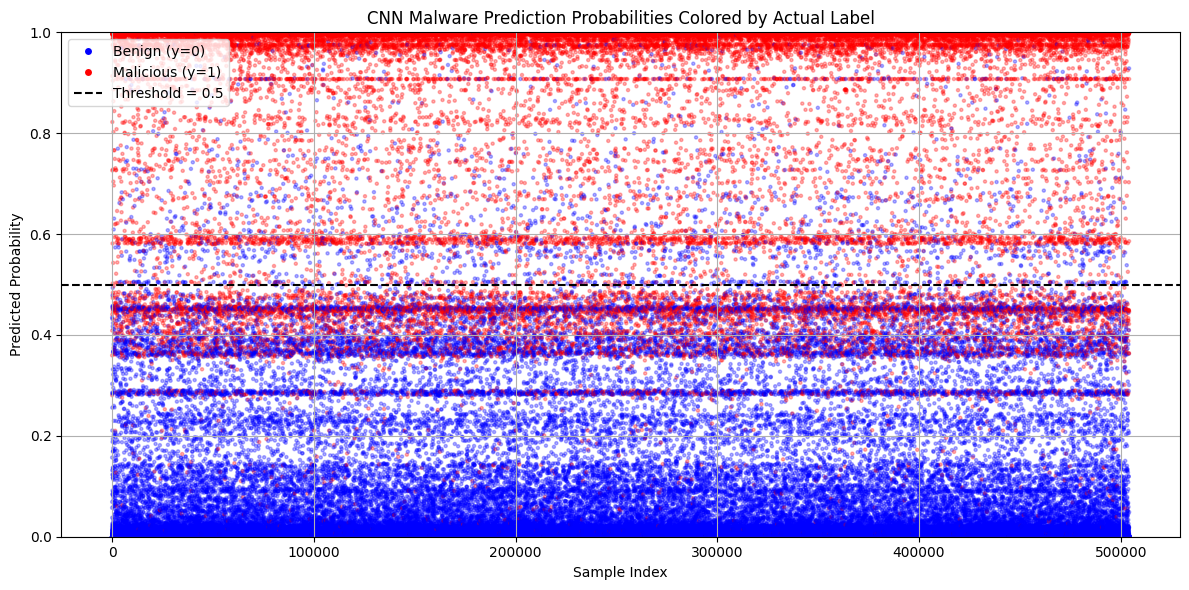

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- Plot CNN Prediction Probabilities ---
# Map actual labels to colors: red = malicious (1), blue = benign (0)
colors = np.where(y_test == 1, 'red', 'blue')

# X-axis = sample index
x_vals = np.arange(len(y_pred_probs))

# Plot predictions with color by actual label
plt.figure(figsize=(12, 6))
plt.scatter(x_vals, y_pred_probs, c=colors, alpha=0.3, s=5)
plt.axhline(y=threshold, color='black', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')

# Labels and styling
plt.ylim([0, 1])
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.title("CNN Malware Prediction Probabilities Colored by Actual Label")

# Add custom legend
custom_lines = [
    plt.Line2D([0], [0], marker='o', color='w', label='Benign (y=0)', markerfacecolor='blue', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='Malicious (y=1)', markerfacecolor='red', markersize=6),
    plt.Line2D([0], [0], color='black', lw=1.5, linestyle='--', label=f'Threshold = {threshold}')
]
plt.legend(handles=custom_lines)

plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2269122754.py:36: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



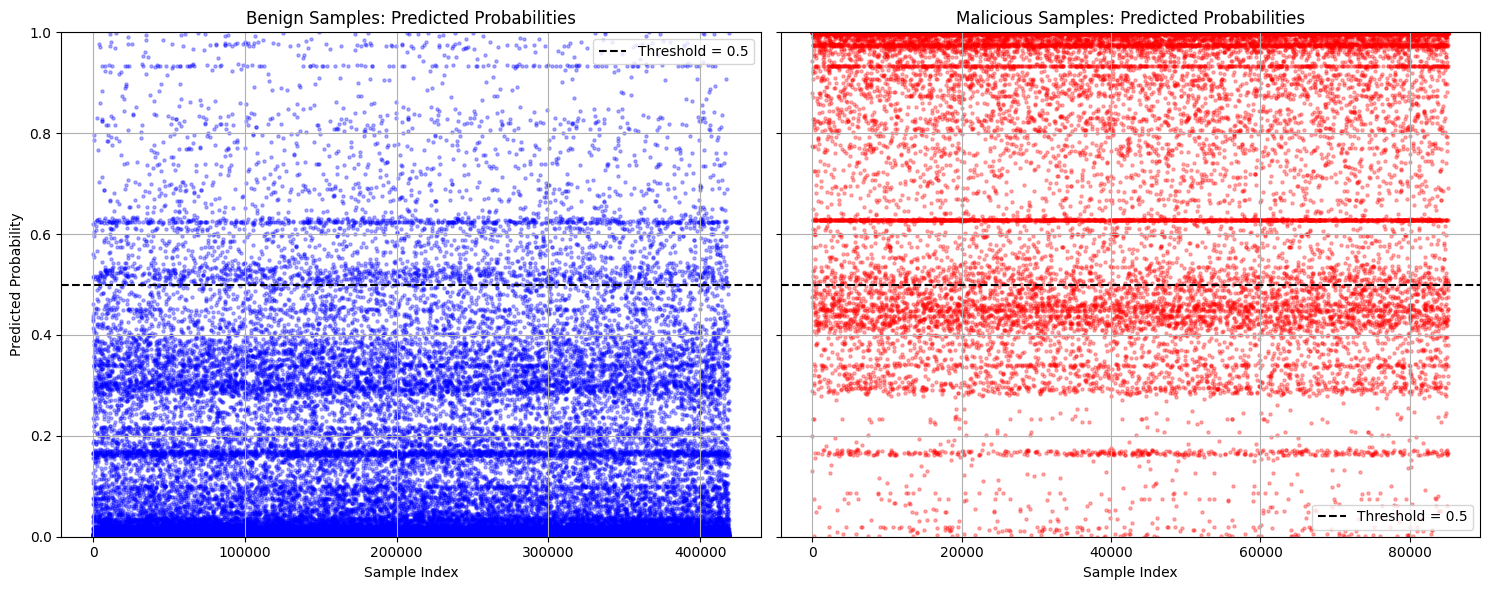

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Separate predictions based on actual labels
benign_indices = np.where(y_test == 0)[0]
malicious_indices = np.where(y_test == 1)[0]

benign_probs = y_pred_probs[benign_indices]
malicious_probs = y_pred_probs[malicious_indices]

benign_x = np.arange(len(benign_probs))
malicious_x = np.arange(len(malicious_probs))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for Benign samples
axes[0].scatter(benign_x, benign_probs, c='blue', alpha=0.3, s=5)
axes[0].axhline(y=threshold, color='black', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Predicted Probability")
axes[0].set_title("Benign Samples: Predicted Probabilities")
axes[0].legend()
axes[0].grid(True)

# Plot for Malicious samples
axes[1].scatter(malicious_x, malicious_probs, c='red', alpha=0.3, s=5)
axes[1].axhline(y=threshold, color='black', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
axes[1].set_ylim([0, 1])
axes[1].set_xlabel("Sample Index")
axes[1].set_title("Malicious Samples: Predicted Probabilities")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()